## Question 1 - Recommender Systems

         item_id  rating  timestamp
user_id                            
685           20      20         20
475           20      20         20
36            20      20         20
732           20      20         20
596           20      20         20 
 



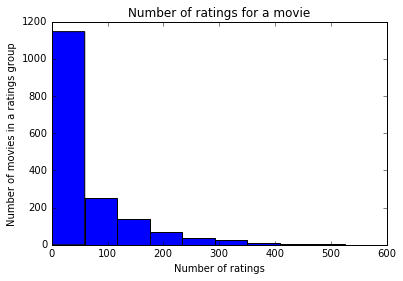

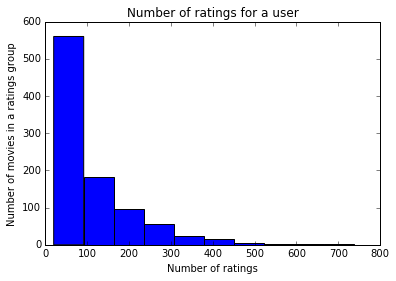

In [31]:
# Required modules 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# Reading in the MovieLens dataset

# Reading the data from u.data
movies = pd.read_csv('./ml-100k/u.data', 
                     sep='\t', names = ['user_id', 'item_id', 'rating', 'timestamp'])

# Looking and confirming the dataset

# Checking if each user has atleast 20 reviews
print(movies.groupby("user_id").agg("count").sort_values(by = "item_id", 
                                                         ascending = False).tail(), "\n", "\n")

# Plotting the histograms

# Checking the number of unique movies
len(movies.item_id.unique()) # 1682 unique movies

### Plotting histograms
# We will group movies by the number of ratings they have received to plot the first 
mov_ratings = movies.groupby("item_id").size()

plt.hist(mov_ratings)
plt.ylabel('Number of movies in a ratings group')
plt.xlabel('Number of ratings')
plt.title("Number of ratings for a movie")
plt.show()
print("\n")

# PLotting in a different manner
usr_ratings = movies.groupby("user_id").agg("count")

plt.hist(usr_ratings["timestamp"])
plt.ylabel('Number of movies in a ratings group')
plt.xlabel('Number of ratings')
plt.title("Number of ratings for a user")
plt.show()


### Part 2 - Build a Recommender System

In [221]:
# Reading in the base and test datasets

mov_base = pd.read_csv('./ml-100k/ua.base', 
                       sep='\t', names = ['user_id', 'item_id', 'rating', 'timestamp'])

mov_test = pd.read_csv('./ml-100k/ua.test', 
                       sep='\t', names = ['user_id', 'item_id', 'rating', 'timestamp'])

# Making the A matrix - User vs the rating for each movie where movies are columns
A = mov_base.pivot(index='user_id', columns='item_id', values='rating')
A = A.fillna(0)

print("Shape of A: ", A.shape, "\n")

# There are two movie values missing
rng = pd.Series(np.arange(1, 1683),dtype=np.float32)
miss = rng[rng.isin(mov_base["item_id"]) == False]
print("Missing columns: ", miss, "\n") #1582, 1653

A["1582"] = 0
A["1653"] = 0

print("Shape of A: ", A.shape, "\n")

# Making a copy for later use
A_orig = A.copy()

# Making the A matrix for the test dataset
# There will be missing movies in the test dataset as well so we will take care of that from the start
item_id = (rng[rng.isin(mov_test["item_id"]) == False]).reset_index()[0]
rating = pd.Series(np.repeat(0, len(test_miss)))
user_id = pd.Series(np.repeat(1, len(test_miss)))

test_fake = pd.concat([user_id, item_id, rating], axis = 1).reset_index(drop = True)
test_fake.columns = ["user_id", "item_id", "rating"]

test_sub = mov_test[["user_id", "item_id", "rating"]]
test_sub = test_sub.append(test_fake)

A_test = test_sub.pivot(index='user_id', columns='item_id', values='rating')
A_test = A_test.fillna(0)
print("Shape of A_test: ", A_test.shape)

Shape of A:  (943, 1680) 

Missing columns:  1581    1582.0
1652    1653.0
dtype: float32 

Shape of A:  (943, 1682) 

Shape of A_test:  (943, 1682)


In [185]:
# Initializing regularizers
# lambda regularizer values
l2 ,l3 = 25 , 10

mu = A.as_matrix()[A != 0].mean().mean()

# Now we will create bi, bu and bui matrices
B = A.as_matrix().copy()

B[B != 0] = B[B != 0] - mu
bi = np.sum(B, axis = 0)/(l2 + (B != 0).sum(axis = 0))

B = (B - bi) * ((B != 0) * 1)
bu = np.sum(B, axis = 1)/(l3 + (B != 0).sum(axis = 1))

# Making the bui matrix
bui = np.full(A.shape, fill_value = mu)
bui = bui + bi + np.tile(bu, (1682,1)).T


In [186]:
# RMSE for baseline
A_t_mat = A_test.as_matrix()

rmse_base = (np.sum(np.square(A_t_mat[A_t_mat != 0] - bui[A_t_mat != 0]))/np.sum(A_t_mat != 0))**0.5

print(" The baseline recommender rmse is {}".format(rmse_base))

 The baseline recommender rmse is 0.9664317139846922


### RMSE Plot per User

In [223]:
# First, we will calculate the average rating per user
A["avg_rating"] = np.mean(A[A!=0], axis = 1)

# Creating 5 bins form the user ratings
user_bins = np.histogram(A["avg_rating"] , bins = 5)[1]

bin_labels = ["Lowest", "Low", "Average", "Good", "Very Good"]

A['categories'] = pd.cut(A['avg_rating'], user_bins, labels = bin_labels)

In [205]:
# Making a bui dataframe with index
bui_df = pd.DataFrame(bui)
bui_df = bui_df.set_index(np.arange(1, 944))

In [214]:
lowest_ids = A[A["categories"] == "Lowest"].index.values
test1 = A_test.loc[lowest_ids].as_matrix()
bui1 = bui_df.loc[lowest_ids].as_matrix()
rmse1 = (np.sum(np.square(test1[test1 != 0] - bui1[test1 != 0]))/np.sum(test1 != 0))**0.5

low_ids = A[A["categories"] == "Low"].index.values
test2 = A_test.loc[low_ids].as_matrix()
bui2 = bui_df.loc[low_ids].as_matrix()
rmse2 = (np.sum(np.square(test2[test2 != 0] - bui2[test2 != 0]))/np.sum(test2 != 0))**0.5

avg_ids = A[A["categories"] == "Average"].index.values
test3 = A_test.loc[avg_ids].as_matrix()
bui3 = bui_df.loc[avg_ids].as_matrix()
rmse3 = (np.sum(np.square(test3[test3 != 0] - bui3[test3 != 0]))/np.sum(test3 != 0))**0.5

good_ids = A[A["categories"] == "Good"].index.values
test4 = A_test.loc[good_ids].as_matrix()
bui4 = bui_df.loc[good_ids].as_matrix()
rmse4 = (np.sum(np.square(test4[test4 != 0] - bui4[test4 != 0]))/np.sum(test4 != 0))**0.5

vgood_ids = A[A["categories"] == "Very Good"].index.values
test5 = A_test.loc[vgood_ids].as_matrix()
bui5 = bui_df.loc[vgood_ids].as_matrix()
rmse5 = (np.sum(np.square(test5[test5 != 0] - bui5[test5 != 0]))/np.sum(test5 != 0))**0.5

rmse_array = np.array([rmse1, rmse2, rmse3, rmse4, rmse5])
                      

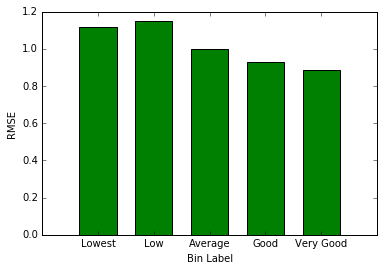

In [216]:
width = 1/1.5
plt.bar(range(len(bin_labels)), rmse_array, width, color="green", align = "center")
plt.xticks(range(len(bin_labels)), bin_labels)
plt.ylabel('RMSE')
plt.xlabel('Bin Label')
plt.show()

#### It is clear from the plot that different bins have a different rmse. There is almost a steady decrease in the RMSE as we move from low rating users to high rating users. This tells us that our recommendation engine works well on users with high rating users. This makes perfect intuitive sense as the users who have rated the movies high will have a better chance of seeing the movie that we recommend them based on that rating. Users that rarely like any movie will have a high chance of not liking the movie we recommend them too. 

## Recommender System based on item similarity

In [257]:
# We will start by creating an empty similarity matrix

A_mat = A_orig.as_matrix()
sim_matrix = np.empty(shape = (A_mat.shape[1],A_mat.shape[1]))

# Making an array for the average user rating
avg_rating = np.array(A["avg_rating"])

# As the matrix is similar, we can only create half of the matrix

for row in list(range(0, A_mat.shape[1] - 1)):
    for col in list(range(row+1 , A_mat.shape[1])):
        
        common = A_mat[:,[row,col]][(A_mat[:,row] != 0) & (A_mat[:,col] != 0)]
        
        if common.size:
            ru1 = common[:,0] - avg_rating[(A_mat[:,row] != 0) & (A_mat[:,col] != 0)]
            ru2 = common[:,1] - avg_rating[(A_mat[:,row] != 0) & (A_mat[:,col] != 0)]
            sim_matrix[row,col] = np.sum(np.multiply(ru1 ,ru2))/ np.sqrt((np.sum(ru1 ** 2) * np.sum(ru2 ** 2)))
        else:
            # For no common users between (i1,i2), we set the similarity value to zero
            sim_matrix[row,col] = 0


# Setting the NAN values to 1
sim_matrix[np.isnan(sim_matrix)]=1
np.fill_diagonal(sim_matrix,1)

# Filling up the whole matrix
lower_indices = np.tril_indices(A.shape[0], -1)
sim_matrix[lower_indices] = sim_matrix.T[lower_indices]


### Running the KNN algorithm using the similarity matrix

### K = 1

In [390]:
# Getting non zero elements from the test set on which we have to make the predictions

def knn_pred(k):
    rows = np.nonzero(A_t_mat)[0]
    columns = np.nonzero(A_t_mat)[1]
    non_zero = zip(rows, columns)

    A_t_pred = np.zeros_like(A_t_mat)
    
    for user, movie in non_zero:
        # Similarity sorting of elements
        cols_train = np.nonzero(A_orig.as_matrix()[user, :])[0]
        cols_train = cols_train[cols_train != movie]
        sim_order = cols_train[np.argsort(sim_matrix[movie, cols_train])[::-1]]

        # Getting the k similar movies already watched by that user, leaving the movie itself
        sim_mov = sim_order[0:k]
        
        #Getting the distances for weighting
        sim_distances = np.sort(sim_matrix[movie, cols_train])[::-1][0:k]

        A_t_pred[user, movie] = np.sum(np.multiply(A_orig.as_matrix()[user, sim_mov], sim_distances))/np.sum(np.absolute(sim_distances))

        if np.isnan(A_t_pred[user, movie]):
            A_t_pred[user, movie] = np.mean(A_orig.as_matrix()[user,:][A_orig.as_matrix()[user,:] != 0])
        
    return A_t_pred

k1_mat = knn_pred(1)

In [391]:
rmse = (np.sum(np.square(A_t_mat[A_t_mat != 0] - k1_mat[A_t_mat != 0]))/np.sum(A_t_mat != 0))**0.5
print(" The rmse for k =", 1, "is", rmse)

 The rmse for k = 1 is 1.36753522916


In [392]:
k1_mat = pd.DataFrame(k1_mat)
k1_mat = k1_mat.set_index(np.arange(1, 944))


k1_mat1 = k1_mat.loc[lowest_ids].as_matrix()
rmse1 = (np.sum(np.square(test1[test1 != 0] - k1_mat1[test1 != 0]))/np.sum(test1 != 0))**0.5

k1_mat2 = k1_mat.loc[low_ids].as_matrix()
rmse2 = (np.sum(np.square(test2[test2 != 0] - k1_mat2[test2 != 0]))/np.sum(test2 != 0))**0.5

k1_mat3 = k1_mat.loc[avg_ids].as_matrix()
rmse3 = (np.sum(np.square(test3[test3 != 0] - k1_mat3[test3 != 0]))/np.sum(test3 != 0))**0.5

k1_mat4 = k1_mat.loc[good_ids].as_matrix()
rmse4 = (np.sum(np.square(test4[test4 != 0] - k1_mat4[test4 != 0]))/np.sum(test4 != 0))**0.5

k1_mat5 = k1_mat.loc[vgood_ids].as_matrix()
rmse5 = (np.sum(np.square(test5[test5 != 0] - k1_mat5[test5 != 0]))/np.sum(test5 != 0))**0.5

rmse_array = np.array([rmse1, rmse2, rmse3, rmse4, rmse5])

In [ ]:
rmse_array

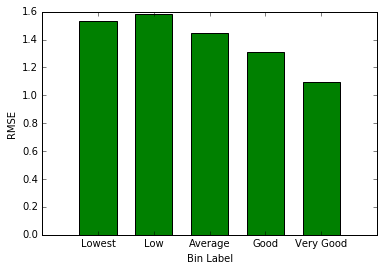

In [394]:
width = 1/1.5
plt.bar(range(len(bin_labels)), rmse_array, width, color="green", align = "center")
plt.xticks(range(len(bin_labels)), bin_labels)
plt.ylabel('RMSE')
plt.xlabel('Bin Label')
plt.show()

### K = 2

In [395]:
k2_mat = knn_pred(2)
rmse = (np.sum(np.square(A_t_mat[A_t_mat != 0] - k2_mat[A_t_mat != 0]))/np.sum(A_t_mat != 0))**0.5
print(" The rmse for k =", 2, "is", rmse)

 The rmse for k = 2 is 1.18837089245


In [396]:
k2_mat = pd.DataFrame(k2_mat)
k2_mat = k2_mat.set_index(np.arange(1, 944))


k2_mat1 = k2_mat.loc[lowest_ids].as_matrix()
rmse1 = (np.sum(np.square(test1[test1 != 0] - k2_mat1[test1 != 0]))/np.sum(test1 != 0))**0.5

k2_mat2 = k2_mat.loc[low_ids].as_matrix()
rmse2 = (np.sum(np.square(test2[test2 != 0] - k2_mat2[test2 != 0]))/np.sum(test2 != 0))**0.5

k2_mat3 = k2_mat.loc[avg_ids].as_matrix()
rmse3 = (np.sum(np.square(test3[test3 != 0] - k2_mat3[test3 != 0]))/np.sum(test3 != 0))**0.5

k2_mat4 = k2_mat.loc[good_ids].as_matrix()
rmse4 = (np.sum(np.square(test4[test4 != 0] - k2_mat4[test4 != 0]))/np.sum(test4 != 0))**0.5

k2_mat5 = k2_mat.loc[vgood_ids].as_matrix()
rmse5 = (np.sum(np.square(test5[test5 != 0] - k2_mat5[test5 != 0]))/np.sum(test5 != 0))**0.5

rmse_array = np.array([rmse1, rmse2, rmse3, rmse4, rmse5])

In [398]:
rmse_array

array([ 1.40528083,  1.42885905,  1.25283004,  1.13082732,  0.98675052])

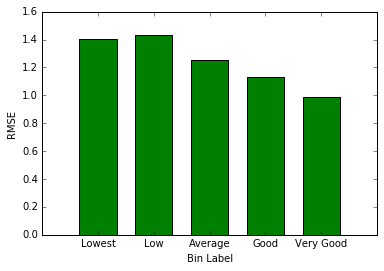

In [397]:
width = 1/1.5
plt.bar(range(len(bin_labels)), rmse_array, width, color="green", align = "center")
plt.xticks(range(len(bin_labels)), bin_labels)
plt.ylabel('RMSE')
plt.xlabel('Bin Label')
plt.show()

### k = 3

In [413]:
k3_mat = knn_pred(3)
rmse = (np.sum(np.square(A_t_mat[A_t_mat != 0] - k3_mat[A_t_mat != 0]))/np.sum(A_t_mat != 0))**0.5
print(" The rmse for k =", 3, "is", rmse)

 The rmse for k = 3 is 1.12126507806


In [414]:
k3_mat = pd.DataFrame(k3_mat)
k3_mat = k3_mat.set_index(np.arange(1, 944))


k3_mat1 = k3_mat.loc[lowest_ids].as_matrix()
rmse1 = (np.sum(np.square(test1[test1 != 0] - k3_mat1[test1 != 0]))/np.sum(test1 != 0))**0.5

k3_mat2 = k3_mat.loc[low_ids].as_matrix()
rmse2 = (np.sum(np.square(test2[test2 != 0] - k3_mat2[test2 != 0]))/np.sum(test2 != 0))**0.5

k3_mat3 = k3_mat.loc[avg_ids].as_matrix()
rmse3 = (np.sum(np.square(test3[test3 != 0] - k3_mat3[test3 != 0]))/np.sum(test3 != 0))**0.5

k3_mat4 = k3_mat.loc[good_ids].as_matrix()
rmse4 = (np.sum(np.square(test4[test4 != 0] - k3_mat4[test4 != 0]))/np.sum(test4 != 0))**0.5

k3_mat5 = k3_mat.loc[vgood_ids].as_matrix()
rmse5 = (np.sum(np.square(test5[test5 != 0] - k3_mat5[test5 != 0]))/np.sum(test5 != 0))**0.5

rmse_array = np.array([rmse1, rmse2, rmse3, rmse4, rmse5])

In [415]:
rmse_array

array([ 1.36900222,  1.35645387,  1.16873985,  1.07600116,  0.93807074])

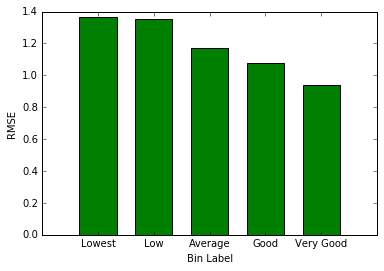

In [416]:
width = 1/1.5
plt.bar(range(len(bin_labels)), rmse_array, width, color="green", align = "center")
plt.xticks(range(len(bin_labels)), bin_labels)
plt.ylabel('RMSE')
plt.xlabel('Bin Label')
plt.show()

### k = 5

In [417]:
k5_mat = knn_pred(5)
rmse = (np.sum(np.square(A_t_mat[A_t_mat != 0] - k5_mat[A_t_mat != 0]))/np.sum(A_t_mat != 0))**0.5
print(" The rmse for k =", 3, "is", rmse)

 The rmse for k = 3 is 1.07781361316


In [418]:
k5_mat = pd.DataFrame(k5_mat)
k5_mat = k5_mat.set_index(np.arange(1, 944))


k5_mat1 = k5_mat.loc[lowest_ids].as_matrix()
rmse1 = (np.sum(np.square(test1[test1 != 0] - k5_mat1[test1 != 0]))/np.sum(test1 != 0))**0.5

k5_mat2 = k5_mat.loc[low_ids].as_matrix()
rmse2 = (np.sum(np.square(test2[test2 != 0] - k5_mat2[test2 != 0]))/np.sum(test2 != 0))**0.5

k5_mat3 = k5_mat.loc[avg_ids].as_matrix()
rmse3 = (np.sum(np.square(test3[test3 != 0] - k5_mat3[test3 != 0]))/np.sum(test3 != 0))**0.5

k5_mat4 = k5_mat.loc[good_ids].as_matrix()
rmse4 = (np.sum(np.square(test4[test4 != 0] - k5_mat4[test4 != 0]))/np.sum(test4 != 0))**0.5

k5_mat5 = k5_mat.loc[vgood_ids].as_matrix()
rmse5 = (np.sum(np.square(test5[test5 != 0] - k5_mat5[test5 != 0]))/np.sum(test5 != 0))**0.5

rmse_array = np.array([rmse1, rmse2, rmse3, rmse4, rmse5])

In [419]:
rmse_array

array([ 1.38754783,  1.33932335,  1.1088744 ,  1.0390081 ,  0.92095547])

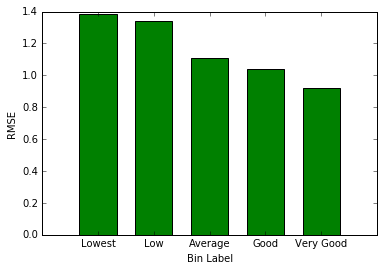

In [420]:
width = 1/1.5
plt.bar(range(len(bin_labels)), rmse_array, width, color="green", align = "center")
plt.xticks(range(len(bin_labels)), bin_labels)
plt.ylabel('RMSE')
plt.xlabel('Bin Label')
plt.show()

### k = 10

In [421]:
k10_mat = knn_pred(10)
rmse = (np.sum(np.square(A_t_mat[A_t_mat != 0] - k10_mat[A_t_mat != 0]))/np.sum(A_t_mat != 0))**0.5
print(" The rmse for k =", 3, "is", rmse)

 The rmse for k = 3 is 1.31937657716


In [422]:
k10_mat = pd.DataFrame(k10_mat)
k10_mat = k10_mat.set_index(np.arange(1, 944))


k10_mat1 = k10_mat.loc[lowest_ids].as_matrix()
rmse1 = (np.sum(np.square(test1[test1 != 0] - k10_mat1[test1 != 0]))/np.sum(test1 != 0))**0.5

k10_mat2 = k10_mat.loc[low_ids].as_matrix()
rmse2 = (np.sum(np.square(test2[test2 != 0] - k10_mat2[test2 != 0]))/np.sum(test2 != 0))**0.5

k10_mat3 = k10_mat.loc[avg_ids].as_matrix()
rmse3 = (np.sum(np.square(test3[test3 != 0] - k10_mat3[test3 != 0]))/np.sum(test3 != 0))**0.5

k10_mat4 = k10_mat.loc[good_ids].as_matrix()
rmse4 = (np.sum(np.square(test4[test4 != 0] - k10_mat4[test4 != 0]))/np.sum(test4 != 0))**0.5

k10_mat5 = k10_mat.loc[vgood_ids].as_matrix()
rmse5 = (np.sum(np.square(test5[test5 != 0] - k10_mat5[test5 != 0]))/np.sum(test5 != 0))**0.5

rmse_array = np.array([rmse1, rmse2, rmse3, rmse4, rmse5])

In [423]:
rmse_array

array([ 1.62898017,  1.85486395,  1.29566695,  1.21674056,  1.66582259])

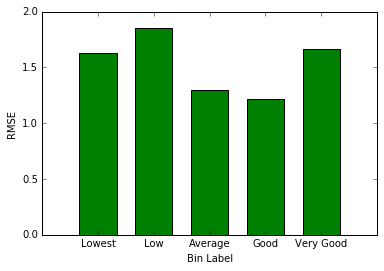

In [424]:
width = 1/1.5
plt.bar(range(len(bin_labels)), rmse_array, width, color="green", align = "center")
plt.xticks(range(len(bin_labels)), bin_labels)
plt.ylabel('RMSE')
plt.xlabel('Bin Label')
plt.show()

### With most of the k values, we see the same trend as the baseline recommender system - the RMSE is higher for low rating user bins and lower for high rating bins. On average the lowest value of rmse is for k = 5 and thus, this could be our most optimal value of k for our data. We also observe that choosing different k values changes the performance for predicting the ratings of our 5 bins. In terms of using all our predictions, we could tailor our selection for k if we want to give a certain bin more importance. We could also take a weighted average of all our predictions and use the averages to make our predictions.
### Our predictions also make sense - using 10 nearest neighbours is a large number as some points which aren't very similar will also be included. On the other hand, 1, 2 and 3 are too few neighbours to get a reasonable average of the user's behavior. Thus 5 hits a sweet spot for us.